In [9]:
from transformers import DPTImageProcessor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

url = "https://imgs.search.brave.com/UwHwjZE8k1318t_094MHplDw1_lhf-nzt03bqpp35Js/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9tLm1l/ZGlhLWFtYXpvbi5j/b20vaW1hZ2VzL00v/TVY1Qk5UYzBPVFF6/TXpneU5sNUJNbDVC/YW5CblhrRnRaVGd3/TVRNNU5EQTBOak1A/LmpwZw"
image = Image.open(requests.get(url, stream=True).raw)

processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

# prepare image for the model
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


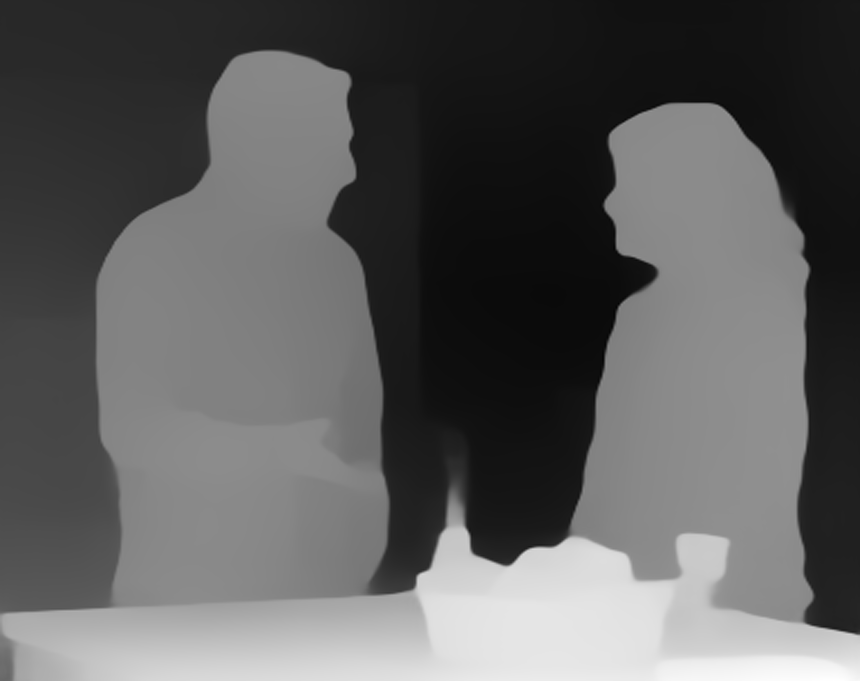

In [11]:
from transformers import pipeline

pipe = pipeline(task="depth-estimation", model="Intel/dpt-large")
result = pipe(image)
result["depth"]